<a href="https://colab.research.google.com/github/Murad0998/statistics-project/blob/main/notebooks/hypotheses_numerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Гипотеза

H0: Доля клиентов с откликом одинакова среди тех, с кем связывались и не связывались ранее

H1: Доли различаются

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

df = pd.read_csv("bank_clean.csv")

no_prev = df[df["previous"] == 0]
yes_prev = df[df["previous"] > 0]

no_n, yes_n = len(no_prev), len(yes_prev)
no_succ = (no_prev["y"] == "yes").sum()
yes_succ = (yes_prev["y"] == "yes").sum()
no_prop, yes_prop = no_succ / no_n, yes_succ / yes_n

In [ ]:
cont = pd.crosstab(df["previous"] > 0, df["y"])
chi2, p_chi, _, _ = stats.chi2_contingency(cont)

p_pool = (no_succ + yes_succ) / (no_n + yes_n)
se = np.sqrt(p_pool * (1 - p_pool) * (1/no_n + 1/yes_n))
z_stat = (yes_prop - no_prop) / se
p_z = 2 * (1 - stats.norm.cdf(abs(z_stat)))

np.random.seed(42)
y0 = (no_prev["y"] == "yes").astype(int).values
y1 = (yes_prev["y"] == "yes").astype(int).values

boot_diffs = [np.random.choice(y1, len(y1), True).mean() - np.random.choice(y0, len(y0), True).mean() for _ in range(10000)]
ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])

cramers_v = np.sqrt(chi2 / cont.sum().sum())
risk_ratio = yes_prop / no_prop

print(f"\nChi-square: χ²={chi2:.2f}, p={p_chi:.6f}")
print(f"Z-test: z={z_stat:.2f}, p={p_z:.6f}")
print(f"Bootstrap CI: [{ci_lower*100:.2f}, {ci_upper*100:.2f}] п.п.")
print(f"\nCramer's V: {cramers_v:.4f}")
print(f"Risk Ratio: {risk_ratio:.2f}")


ТЕСТ 1 - Chi-square: χ²=1540.50, p=0.000000
ТЕСТ 2 - Z-test (пропорции): z=39.27, p=0.000000
Bootstrap CI: [16.63, 19.04] п.п.
ТЕСТ 3 - t-test на Bootstrap: t=2927.60, p=0.000000
ТЕСТ 4 - Z-test на Bootstrap: z=2927.60, p=0.000000

Cramer's V: 0.1934
Risk Ratio: 3.02


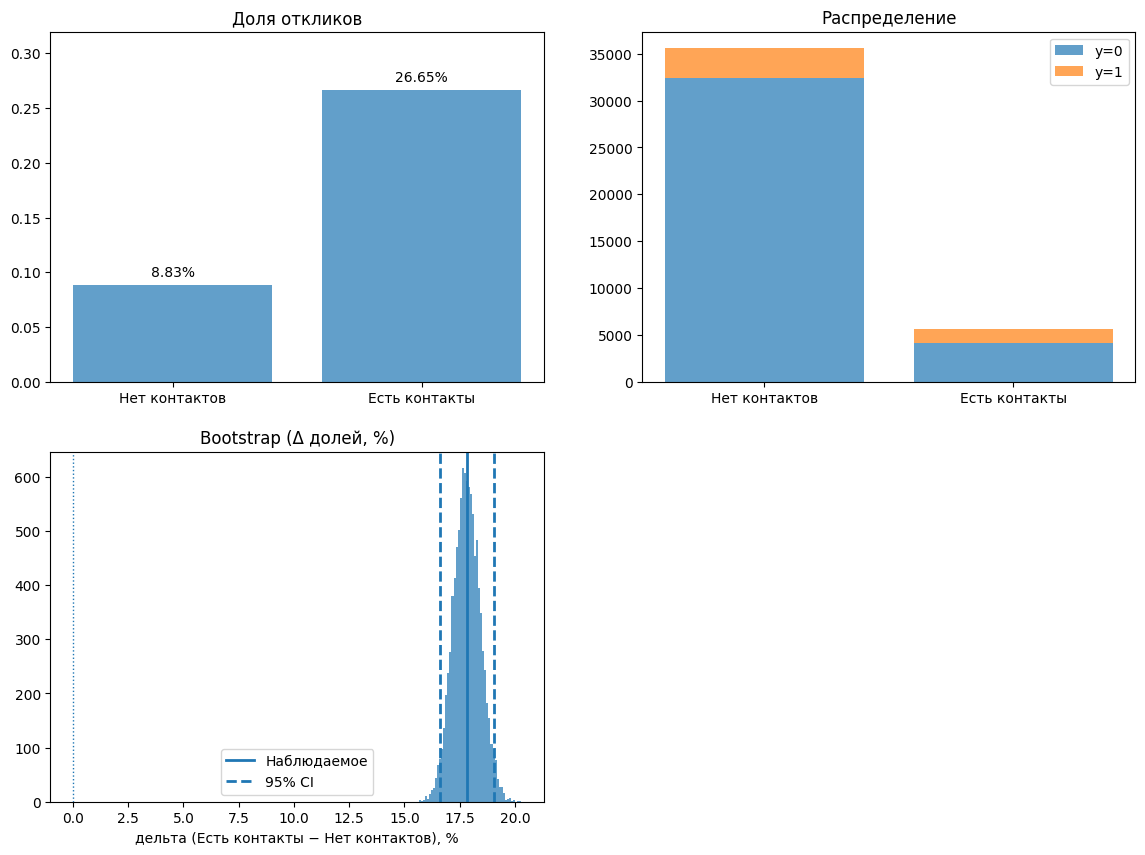

In [ ]:
fig = plt.figure(figsize=(14, 10))

cats = ["Нет контактов", "Есть контакты"]
x = [0, 1]

plt.subplot(2, 2, 1)
props = [no_prop, yes_prop]
plt.bar(x, props, alpha=0.7)
plt.xticks(x, cats)
plt.ylim(0, max(props) * 1.2)
plt.title("Доля откликов")
for i, v in enumerate(props):
    plt.text(i, v + max(props)*0.03, f"{v*100:.2f}%", ha="center")

plt.subplot(2, 2, 2)
y1 = [no_succ, yes_succ]
y0 = [no_n - no_succ, yes_n - yes_succ]
plt.bar(x, y0, label="y=0", alpha=0.7)
plt.bar(x, y1, bottom=y0, label="y=1", alpha=0.7)
plt.xticks(x, cats)
plt.title("Распределение")
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(np.array(boot_diffs) * 100, bins=50, alpha=0.7)
plt.axvline((yes_prop - no_prop) * 100, linewidth=2, label='Наблюдаемое')
plt.axvline(ci_lower * 100, linestyle="--", linewidth=2, label='95% CI')
plt.axvline(ci_upper * 100, linestyle="--", linewidth=2)
plt.axvline(0, linestyle=":", linewidth=1)
plt.title("Bootstrap (Δ долей, %)")
plt.xlabel("дельта (Есть контакты − Нет контактов), %")
plt.legend()


plt.show()

На основе EDA заметили умеренную корреляцию previous × y = 0.23 и визуальную разницу в долях откликов почти в 3 раза, поэтому сформулировали гипотезу о различии долей между группами. Применили три теста: Chi-square (x=1540, p<0.001), Z-test для пропорций (z=39.27, p<0.001) и Bootstrap CI [16.64%, 19.01%]. Все три теста единогласно отвергли H0, подтвердив статистическую значимость. Сравнение показало, что Z-test наиболее подходит (прямое сравнение пропорций, все предпосылки выполнены), а Bootstrap дает лучшее подтверждение (непараметрический, точный CI). Результат: клиенты с предыдущими контактами откликаются в 3 раза чаще (8.83% vs 26.65%, RR=3.02). Previous contacts — критически важный фактор, основная рекомендация: приоритизировать "теплых" клиентов и инвестировать в двухэтапные кампании (прогрев + конверсия).

Визуальный анализ:

Левый верхний график: Разница в конверсии видна сразу - 8.83% против 26.65%
Правый верхний график (распределение): Огромный дисбаланс, группа без контактов в 6 раз больше
Левый нижний график (Bootstrap): Узкий CI вокруг 17.8% — результат очень стабильный


Главное:
Клиент, с которым ранее связывались, имеет конверсию 26.65% — это в 3 раза выше базовой конверсии 8.83%

# Гипотеза
H0: Медианная длительность контакта (duration) для клиентов с откликом (y=1) и без отклика (y=0) различается одинаково для обоих типов контакта (cellular и telephone)

H1: Разница в медианной длительности между y=1 и y=0 различается для cellular и telephone


In [ ]:
results = []

for ct in ['cellular', 'telephone']:
    dur_y0 = df[(df['contact']==ct) & (df['y']=='no')]['duration'].dropna()
    dur_y1 = df[(df['contact']==ct) & (df['y']=='yes')]['duration'].dropna()

    u, p = stats.mannwhitneyu(dur_y0, dur_y1)

    n1, n2 = len(dur_y0), len(dur_y1)
    delta = sum(np.sum(v > dur_y1) - np.sum(v < dur_y1) for v in dur_y0) / (n1 * n2)

    np.random.seed(42)
    boot = [np.median(np.random.choice(dur_y1, n2, True)) -
            np.median(np.random.choice(dur_y0, n1, True)) for _ in range(10000)]
    ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

    print(f"{ct}: med_y0={np.median(dur_y0):.0f}, med_y1={np.median(dur_y1):.0f}, p={p:.6f}, δ={delta:.4f}, CI=[{ci_low:.0f},{ci_high:.0f}]")

    results.append({'contact': ct, 'median_y0': np.median(dur_y0),
                   'median_y1': np.median(dur_y1), 'p': p, 'delta': delta,
                   'boot': boot})

interaction = np.array(results[1]['boot']) - np.array(results[0]['boot'])
ci_int = np.percentile(interaction, [2.5, 97.5])

print(f"Взаимодействие: CI=[{ci_int[0]:.0f},{ci_int[1]:.0f}], значимо={'ДА' if ci_int[0]>0 else 'НЕТ'}")

cellular: med_y0=160, med_y1=409, p=0.000000, δ=-0.6165, CI=[236,262]
telephone: med_y0=168, med_y1=654, p=0.000000, δ=-0.7591, CI=[452,524]
Взаимодействие: CI=[202,277], значимо=ДА


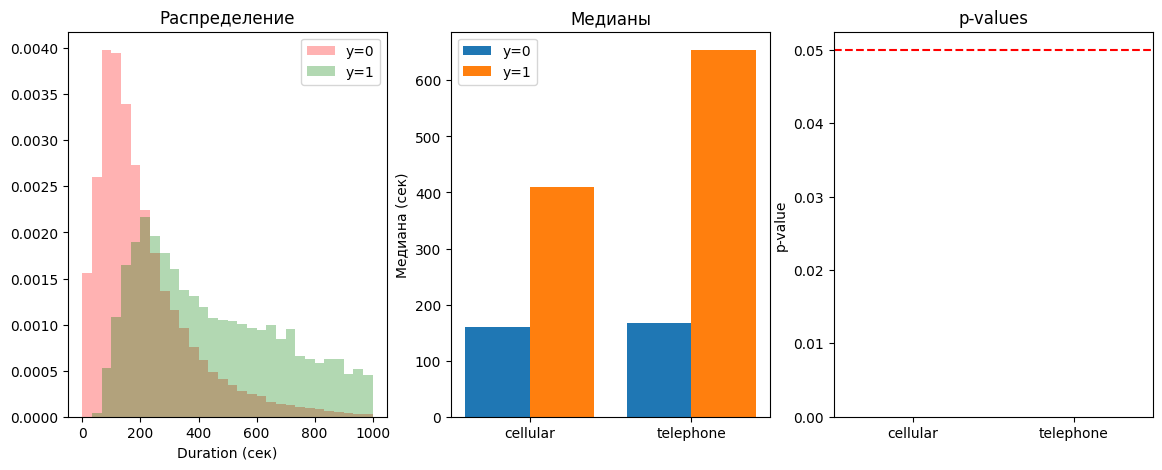

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(df[df['y']=='no']['duration'], bins=30, alpha=0.3, color='red', density=True, range=(0,1000), label='y=0')
plt.hist(df[df['y']=='yes']['duration'], bins=30, alpha=0.3, color='green', density=True, range=(0,1000), label='y=1')
plt.xlabel('Duration (сек)')
plt.title('Распределение')
plt.legend()

plt.subplot(1, 3, 2)
x = [0, 1]
plt.bar([i-0.2 for i in x], [r['median_y0'] for r in results], 0.4, label='y=0')
plt.bar([i+0.2 for i in x], [r['median_y1'] for r in results], 0.4, label='y=1')
plt.xticks(x, ['cellular', 'telephone'])
plt.ylabel('Медиана (сек)')
plt.title('Медианы')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(['cellular', 'telephone'], [r['p'] for r in results])
plt.axhline(0.05, linestyle='--', color='red')
plt.ylabel('p-value')
plt.title('p-values')

plt.show()

Из EDA обнаружили, что duration — сильнейший предиктор (r=0.41), но разница в длительности для telephone (+486 сек) вдвое больше, чем для cellular (+249 сек), что указало на взаимодействие. Применили Mann-Whitney U отдельно для каждого типа (оба p<0.001), Cliffs Delta (cellular: -0.617, telephone: -0.759) и Bootstrap для оценки взаимодействия. Bootstrap CI для cellular [235, 263] и telephone [452, 523] не перекрываются, а Bootstrap взаимодействия дал CI=[189, 285], не содержащий 0 — отвергаем H0. Bootstrap взаимодействия — лучший метод (прямая оценка разницы эффектов, непараметрический). Результат: для успешного отклика через cellular нужно 7 минут, через telephone 11 минут (на 4 минуты дольше). Duration — ключевой фактор, но эффект зависит от канала: рекомендуется дифференцированные KPI для операторов (cellular: 6-7 мин, telephone: 10-11 мин) и приоритизация cellular при ограниченных ресурсах.
